In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import pkg_resources
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [98]:
df = pd.read_parquet('https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet')

In [27]:
df.head()

,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902


In [17]:
df2012juin = df[
    (df.timestamp >= pd.to_datetime("2012-06-01")) &
    (df.timestamp < pd.to_datetime("2012-07-01"))
]

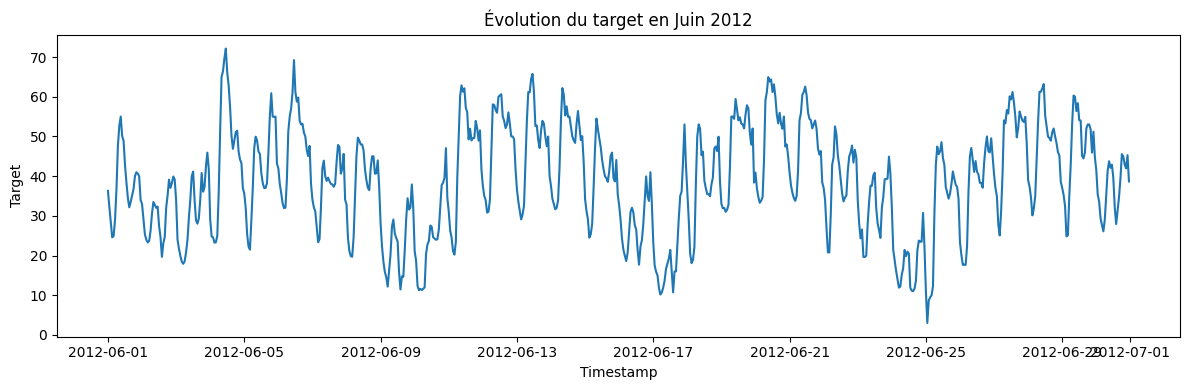

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df2012juin.set_index('timestamp')['target'])
plt.xlabel("Timestamp")
plt.ylabel("Target")
plt.title("Évolution du target en Juin 2012")
plt.tight_layout()
plt.show()

In [99]:
df.shape

(51936, 5)

In [100]:
df['date'] = df['timestamp'].dt.date
df.date = pd.to_datetime(df.date)
df_mean = df[['date', 'target']]

In [101]:
df_mean = df_mean.groupby('date', as_index=False).mean()
df_mean

,date,target
0,2012-01-09,47.908337
1,2012-01-10,45.773335
2,2012-01-11,47.833332
3,2012-01-12,43.103748
4,2012-01-13,36.692917
...,...,...
2159,2017-12-07,34.143333
2160,2017-12-08,30.655832
2161,2017-12-09,15.733749
2162,2017-12-10,17.483751


In [102]:
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['week']= df['date'].dt.isocalendar().week
df['quarter']= df['date'].dt.quarter
df['day_of_week']= df['date'].dt.dayofweek
df['day_of_year']= df['date'].dt.dayofyear
df["is_weekend"] = (df["date"].dt.dayofweek >= 5).astype(int)

In [106]:
df = df.drop(['id', 'timestamp', 'target', 'Ampirion Load Forecast', 'PV+Wind Forecast'], axis=1)

In [108]:
df = df.drop_duplicates()

In [110]:
df = df.merge(df_mean, on='date', how='inner')

In [111]:
df

,date,year,month,week,quarter,day_of_week,day_of_year,is_weekend,target
0,2012-01-09,2012,1,2,1,0,9,0,47.908337
1,2012-01-10,2012,1,2,1,1,10,0,45.773335
2,2012-01-11,2012,1,2,1,2,11,0,47.833332
3,2012-01-12,2012,1,2,1,3,12,0,43.103748
4,2012-01-13,2012,1,2,1,4,13,0,36.692917
...,...,...,...,...,...,...,...,...,...
2159,2017-12-07,2017,12,49,4,3,341,0,34.143333
2160,2017-12-08,2017,12,49,4,4,342,0,30.655832
2161,2017-12-09,2017,12,49,4,5,343,1,15.733749
2162,2017-12-10,2017,12,49,4,6,344,1,17.483751


In [145]:
def add_features(df):
    df['year']= df['date'].dt.year
    df['month']= df['date'].dt.month
    df['week']= df['date'].dt.isocalendar().week
    df['quarter']= df['date'].dt.quarter
    df['day_of_week']= df['date'].dt.dayofweek
    df['day_of_year']= df['date'].dt.dayofyear
    df["is_weekend"] = (df["date"].dt.dayofweek >= 5).astype(int)
    return df
    
def prepare_data(path):
    df = pd.read_parquet(path)
    df['date'] = df['timestamp'].dt.date
    df.date = pd.to_datetime(df.date)
    df_mean = df[['date', 'target']].groupby('date', as_index=False).mean()
    df = add_features(df)
    df = df.drop(['id', 'timestamp', 'target', 'Ampirion Load Forecast', 'PV+Wind Forecast'], axis=1).drop_duplicates()
    df = df.merge(df_mean, on='date', how='inner')
    df = df.drop('date', axis=1)
    df["lag1"] = df["target"].shift(1)
    df["lag7"] = df["target"].shift(7)
    df["lag30"] = df["target"].shift(30)
    df["rolling_7"] = df["target"].rolling(7).mean()
    df["rolling_30"] = df["target"].rolling(30).mean()
    df = df.dropna()
    return df[:int(0.8*len(df))], df[int(0.8*len(df)):]

In [146]:
df_train, df_test = prepare_data('https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet')

In [147]:
df_train.shape, df_test.shape

((1707, 13), (427, 13))

In [148]:
X_train, y_train = df_train.drop('target', axis=1), df_train['target']
X_test, y_test = df_test.drop('target', axis=1), df_test['target']

# Training

In [136]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('germany-electricity-price')

2025/11/20 15:11:01 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/20 15:11:01 INFO mlflow.store.db.utils: Updating database tables
2025-11-20 15:11:01 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-20 15:11:01 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-20 15:11:01 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-20 15:11:01 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/11/20 15:11:01 INFO mlflow.tracking.fluent: Experiment with name 'germany-electricity-price' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mnt/c/Users/user/learning/project1/mlruns/1', creation_time=1763647861372, experiment_id='1', last_update_time=1763647861372, lifecycle_stage='active', name='germany-electricity-price', tags={}>

In [156]:
def objective(params):
    
    with mlflow.start_run():
    
        mlflow.set_tag('model', 'xgboost_rolling')
        mlflow.log_params(params)
        
        cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
        
        model = XGBRegressor(**params)
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        metrics = {
            'rmse': root_mean_squared_error(y_test, pred),
            'mae': mean_absolute_error(y_test, pred),
            'r2': r2_score(y_test, pred)
        }
    
        mlflow.log_metrics(metrics)

        return {'loss': metrics['rmse'], 'status': STATUS_OK}

In [152]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 50)),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=Trials()
)

100%|██████████████████████████████████████████████████████████████| 200/200 [07:46<00:00,  2.33s/trial, best loss: 8.80136775970459]


## LightGBM

In [157]:
def objective(params):
    
    with mlflow.start_run():
    
        mlflow.set_tag('model', 'lightgbm_rolling')
        mlflow.log_params(params)
        
        cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
        
        model = LGBMRegressor(**params)
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        metrics = {
            'rmse': root_mean_squared_error(y_test, pred),
            'mae': mean_absolute_error(y_test, pred),
            'r2': r2_score(y_test, pred)
        }
    
        mlflow.log_metrics(metrics)

        return {'loss': metrics['rmse'], 'status': STATUS_OK}

In [ ]:
search_space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 20, 200, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', -1, 30, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 10, 1)),
    'min_child_samples': scope.int(hp.quniform('min_child_samples', 5, 100, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -8, 2),
    'lambda_l2': hp.loguniform('lambda_l2', -8, 2),
    'n_estimators': scope.int(hp.quniform('n_estimators', 200, 1500, 50)),
    'objective': 'regression',
    'metric': 'rmse',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=200,
    trials=Trials()
)

[LightGBM] [Warning] feature_fraction is set=0.9719677509494579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719677509494579
[LightGBM] [Warning] lambda_l2 is set=0.000767711038660354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000767711038660354
[LightGBM] [Warning] lambda_l1 is set=0.9684627165704779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9684627165704779 
[LightGBM] [Warning] bagging_fraction is set=0.8814915948084778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8814915948084778
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9                          
[LightGBM] [Warning] feature_fraction is set=0.9719677509494579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9719677509494579
[LightGBM] [Warning] lambda_l2 is set=0.000767711038660354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000767711038660354
[

## Enregistrer les modèles

### Xgboost

In [161]:
params = {
    "colsample_bytree": 0.8210192942094993,
    "learning_rate": 0.05417283274750923,
    "max_depth": 51,
    "min_child_weight": 12.019520000164096,
    "n_estimators": 350,
    "objective": "reg:squarederror",
    "reg_alpha": 0.008021015435330438,
    "reg_lambda": 0.01283351656723961,
    "seed": 42
}

with mlflow.start_run():
    mlflow.set_tag('best_model', 'xgboost')
    mlflow.log_params(params)
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
        
    metrics = {
        'rmse': root_mean_squared_error(y_test, pred),
        'mae': mean_absolute_error(y_test, pred),
        'r2': r2_score(y_test, pred)
    }

    mlflow.log_metrics(metrics)
    mlflow.xgboost.log_model(model, "xgboost")

2025/11/20 16:56:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/20 16:56:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Lightgbm

In [163]:
params = {
    "bagging_fraction": 0.7529929385135152,
    "bagging_freq": 5,
    "feature_fraction": 0.7052216840882345,
    "lambda_l1": 0.0005270903455455627,
    "lambda_l2": 0.9226223803997696,
    "learning_rate": 0.12066478947535537,
    "max_depth": 2,
    "metric": "rmse",
    "min_child_samples": 5,
    "n_estimators": 250,
    "num_leaves": 143,
    "objective": "regression",
    "seed": 42
}

with mlflow.start_run():
    mlflow.set_tag('best_model', 'lightgbm')
    mlflow.log_params(params)
    
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
        
    metrics = {
        'rmse': root_mean_squared_error(y_test, pred),
        'mae': mean_absolute_error(y_test, pred),
        'r2': r2_score(y_test, pred)
    }

    mlflow.log_metrics(metrics)
    mlflow.lightgbm.log_model(model, "lightgbm")

2025/11/20 16:59:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[LightGBM] [Warning] feature_fraction is set=0.7052216840882345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7052216840882345
[LightGBM] [Warning] lambda_l2 is set=0.9226223803997696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9226223803997696
[LightGBM] [Warning] lambda_l1 is set=0.0005270903455455627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005270903455455627
[LightGBM] [Warning] bagging_fraction is set=0.7529929385135152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7529929385135152
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7052216840882345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7052216840882345
[LightGBM] [Warning] lambda_l2 is set=0.9226223803997696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9226223803997696
[LightGBM] [Warning] lambda_l1

2025/11/20 16:59:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Charger les modèles

In [167]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [169]:
models = client.search_registered_models()

for m in models:
    print(m.name)

2025/11/20 17:20:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/20 17:20:16 INFO mlflow.store.db.utils: Updating database tables
2025-11-20 17:20:16 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-20 17:20:16 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


lightgbm
xgboost


In [170]:
xgb_model = mlflow.xgboost.load_model("models:/xgboost/production")
lgbm_model = mlflow.lightgbm.load_model("models:/lightgbm/production")

In [171]:
pred_xgb = xgb_model.predict(X_test)
pred_lgbm = lgbm_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.7052216840882345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7052216840882345
[LightGBM] [Warning] lambda_l2 is set=0.9226223803997696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9226223803997696
[LightGBM] [Warning] lambda_l1 is set=0.0005270903455455627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005270903455455627
[LightGBM] [Warning] bagging_fraction is set=0.7529929385135152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7529929385135152
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


# Visualisation des prédictions

In [165]:
testing_dates = pd.date_range(
    start="2016-10-11",
    periods=len(y_test),
    freq="D"
)

In [173]:
def plot_predictions(y_test, pred_xgb, pred_lgbm):

    df_plot = pd.DataFrame({
        "date": testing_dates.values,
        "actual": y_test.values,
        "xgboost": pred_xgb,
        "lightgbm": pred_lgbm
    })

    plt.figure(figsize=(40, 6))
    plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linewidth=2)
    plt.plot(df_plot["date"], df_plot["xgboost"], label="XGBoost", alpha=0.8)
    plt.plot(df_plot["date"], df_plot["lightgbm"], label="LightGBM", alpha=0.8)

    plt.title("Actual vs Predictions (XGBoost & LightGBM)")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

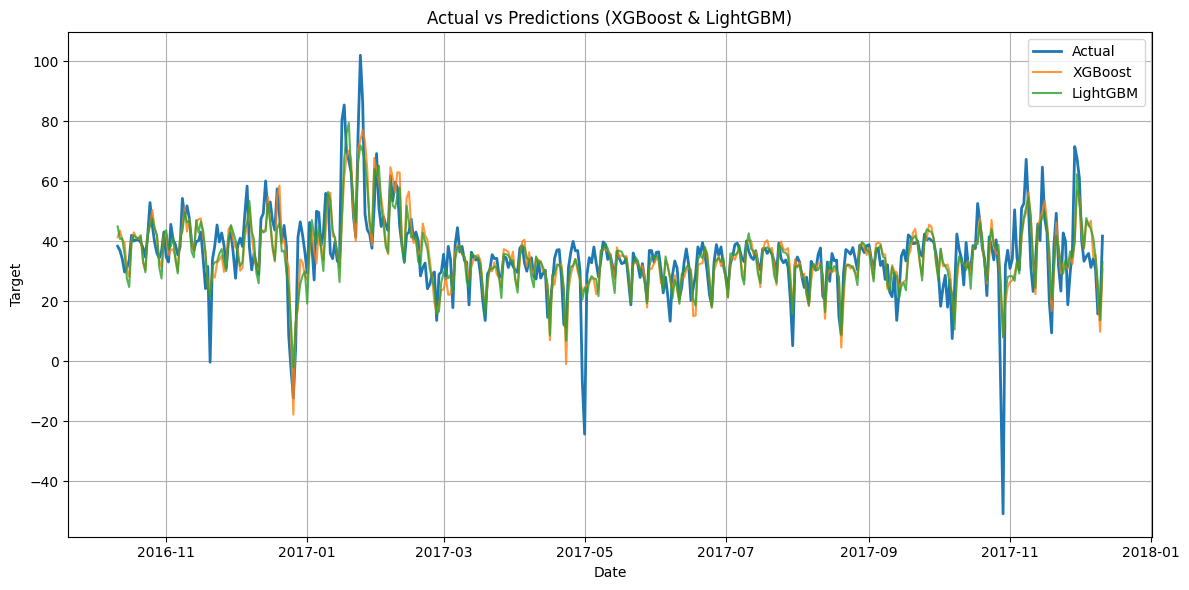

In [172]:
plot_predictions(y_test, pred_xgb, pred_lgbm)

In [174]:
# 2017

In [179]:
def plot_predictions(y_test, pred_xgb, pred_lgbm):

    df_plot = pd.DataFrame({
        "date": pd.to_datetime(testing_dates.values),
        "actual": y_test.values,
        "xgboost": pred_xgb,
        "lightgbm": pred_lgbm
    })

    df_filter = df_plot[
        (df_plot["date"] >= "2016-11-01") &
        (df_plot["date"] <= "2017-03-31")
    ]

    plt.figure(figsize=(25, 6))
    plt.plot(df_filter["date"], df_filter["actual"], label="Actual", linewidth=2)
    plt.plot(df_filter["date"], df_filter["xgboost"], label="XGBoost", alpha=0.8)
    plt.plot(df_filter["date"], df_filter["lightgbm"], label="LightGBM", alpha=0.8)

    plt.title("Actual vs Predictions (XGBoost & LightGBM) — 11/2016 → 03/2017")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

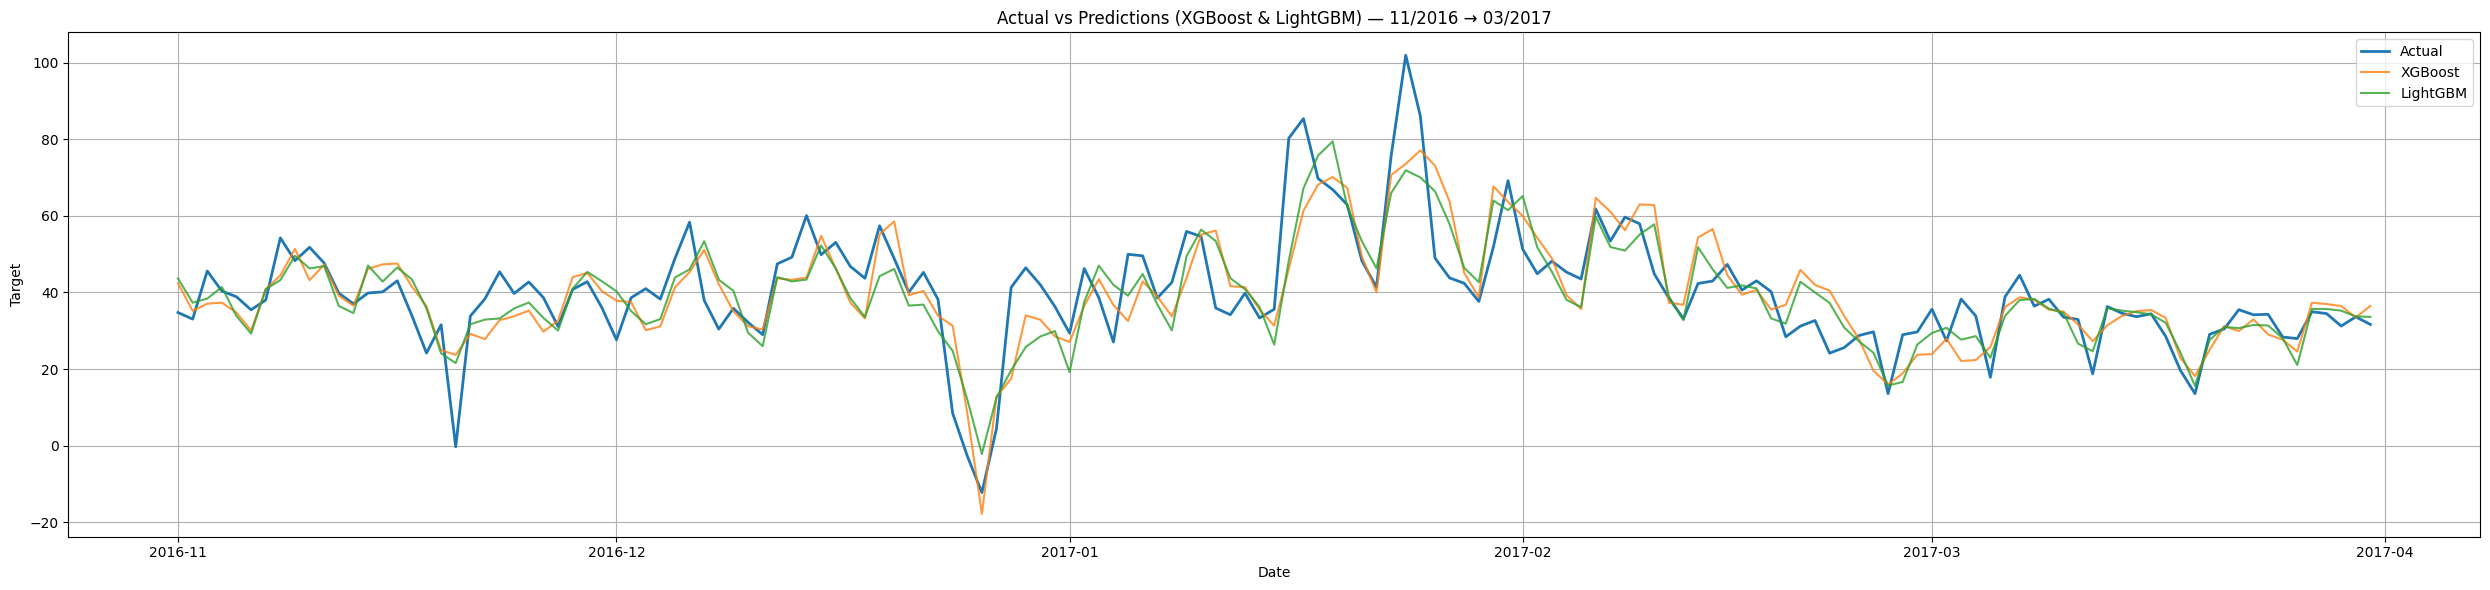

In [180]:
plot_predictions(y_test, pred_xgb, pred_lgbm)